Process Wu et al slides

In [21]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq

In [65]:
slide_names = ['1142243F', '1160920F', 'CID4290', 'CID4465', 'CID44971', 'CID4535']

In [66]:
data_dir = os.path.join('..', '..', 'data', 'wu_et_al')

Load Junk Breast Cancer data

In [67]:
for slide_name in slide_names:
    
    adata = sc.read_h5ad(os.path.join(data_dir, slide_name, f"{slide_name}.h5ad"))
    del adata.layers['logcounts']
    from squidpy._constants._pkg_constants import Key
    import json
    from pathlib import Path
    from squidpy.read._utils import _load_image, _read_counts
    from squidpy.datasets._utils import PathLike
    
    library_id = slide_name
    path = Path(os.path.join(data_dir, slide_name))
    adata.uns[Key.uns.spatial] = {}
    adata.uns[Key.uns.spatial][library_id] = {}
    
    adata.uns[Key.uns.spatial][library_id][Key.uns.image_key] = {
    res: _load_image(path / f"{Key.uns.spatial}/tissue_{res}_image.png") for res in ["hires", "lowres"]
    }
    adata.uns[Key.uns.spatial][library_id]["scalefactors"] = json.loads(
        (path / f"{Key.uns.spatial}/scalefactors_json.json").read_bytes()
    )
    
    tissue_positions_file = (
    path / "spatial/tissue_positions.csv"
    if (path / "spatial/tissue_positions.csv").exists()
    else path / "spatial/tissue_positions_list.csv"
    )

    coords = pd.read_csv(
        tissue_positions_file,
        header=1 if tissue_positions_file.name == "tissue_positions.csv" else None,
        index_col=0,
    )
    coords.columns = ["in_tissue", "array_row", "array_col", "pxl_col_in_fullres", "pxl_row_in_fullres"]
    # https://github.com/scverse/squidpy/issues/657
    coords.set_index(coords.index.astype(adata.obs.index.dtype), inplace=True)

    adata.obs = pd.merge(adata.obs, coords, how="left", left_index=True, right_index=True)
    adata.obsm[Key.obsm.spatial] = adata.obs[["pxl_row_in_fullres", "pxl_col_in_fullres"]].values
    adata.obs.drop(columns=["pxl_row_in_fullres", "pxl_col_in_fullres"], inplace=True)
    
    obs = pd.read_csv(os.path.join(data_dir, slide_name, "metadata.csv"), index_col=0)
    adata.obs = adata.obs.merge(obs, left_index=True, right_index=True)

    adata.write_h5ad(os.path.join(data_dir, f"{slide_name}.h5ad"))

In [35]:
sq.gr.spatial_neighbors(adata)

In [50]:
import liana as li
from liana.mt.sp import lr_basis

In [43]:
lr_basis(adata, function_name='pearson', proximity_key='spatial_connectivities', use_raw=False)

In [52]:
lr = li.fun.obsm_to_adata(adata, 'local_scores')

In [55]:
adata.uns['global_res'].sort_values('global_mean', ascending=False)

,ligand,receptor,ligand_means,ligand_props,receptor_means,receptor_props,interaction,global_mean,global_sd
794,HLA-A,ERBB2,24.892099,0.997957,14.665530,0.957099,HLA-A&ERBB2,0.417107,0.423451
802,HSP90AA1,ERBB2,7.944031,0.940143,14.665530,0.957099,HSP90AA1&ERBB2,0.367891,0.436961
3648,TIMP1,CD63,9.919719,0.981001,4.739771,0.939122,TIMP1&CD63,0.321088,0.434704
642,HLA-B,CANX,37.290428,0.998161,2.151793,0.789581,HLA-B&CANX,0.303515,0.437109
803,HSP90B1,ERBB2,4.310342,0.912972,14.665530,0.957099,HSP90B1&ERBB2,0.284683,0.454515
...,...,...,...,...,...,...,...,...,...
1109,CD59,CD2,7.241878,0.926047,0.387133,0.269663,CD59&CD2,-0.014635,0.396877
814,APOE,LRP6,19.951483,0.995710,0.292750,0.234934,APOE&LRP6,-0.014908,0.389197
2705,CXCL10,ACKR1,2.449655,0.673749,0.252707,0.134219,CXCL10&ACKR1,-0.015558,0.286664
2648,APOC2,LDLR,0.131358,0.109908,0.219817,0.184883,APOC2&LDLR,-0.015631,0.244453


In [61]:
lr.obs

,orig.ident,nCount_Spatial,nFeature_Spatial,ident,in_tissue,array_row,array_col,nCount_RNA,nFeature_RNA,patientid,subtype,Classification
TGTTGGCTGGCGGAAG-1,SeuratProject,3685.0,1441,SeuratProject,1,1,5,3685,1441,1160920F,TNBC,Adipose tissue
GCATCCTCTCCTATTA-1,SeuratProject,4526.0,1829,SeuratProject,1,0,6,4526,1829,1160920F,TNBC,Adipose tissue
GCGAGGGACTGCTAGA-1,SeuratProject,4171.0,1668,SeuratProject,1,1,7,4171,1668,1160920F,TNBC,Adipose tissue
TGGTACCGGCACAGCC-1,SeuratProject,4722.0,1837,SeuratProject,1,0,8,4722,1837,1160920F,TNBC,Adipose tissue
GCGCGTTTAAATCGTA-1,SeuratProject,5547.0,2217,SeuratProject,1,1,9,5547,2217,1160920F,TNBC,Adipose tissue
...,...,...,...,...,...,...,...,...,...,...,...,...
AGAGTCTTAATGAAAG-1,SeuratProject,21320.0,5749,SeuratProject,1,76,122,21320,5749,1160920F,TNBC,Invasive cancer + stroma + lymphocytes
GAACGTTTGTATCCAC-1,SeuratProject,6903.0,2945,SeuratProject,1,77,123,6903,2945,1160920F,TNBC,Invasive cancer + stroma + lymphocytes
ATTGAATTCCCTGTAG-1,SeuratProject,11408.0,4043,SeuratProject,1,76,124,11408,4043,1160920F,TNBC,Invasive cancer + stroma + lymphocytes
TACCTCACCAATTGTA-1,SeuratProject,6722.0,2651,SeuratProject,1,77,125,6722,2651,1160920F,TNBC,Invasive cancer + stroma + lymphocytes


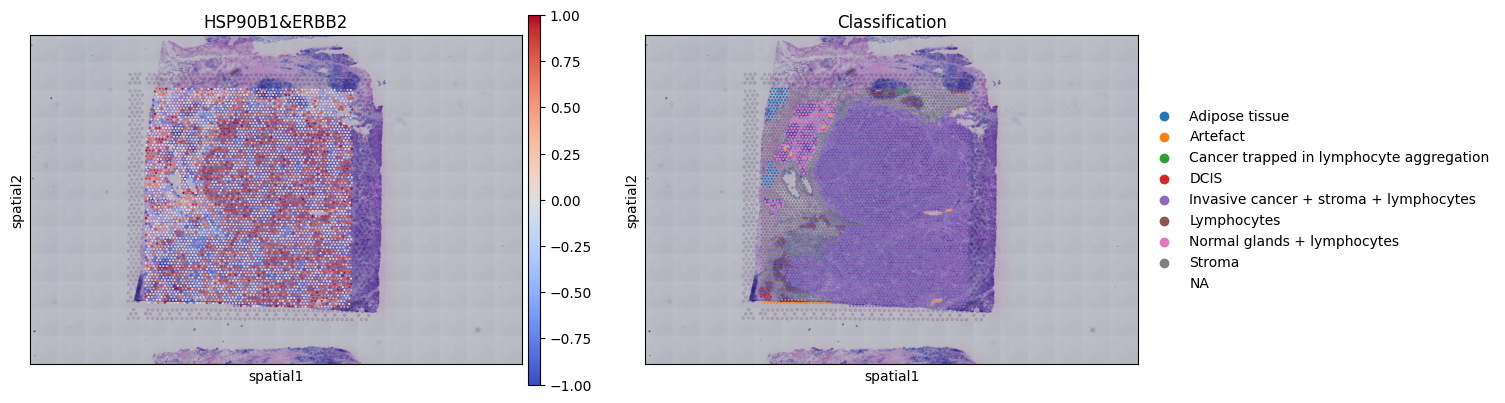

In [64]:
sq.pl.spatial_scatter(lr, color=['HSP90B1&ERBB2', 'Classification'], cmap='coolwarm')

In [34]:
?sq.gr.spatial_neighbors

Signature:
sq.gr.spatial_neighbors(
    adata: 'AnnData',
    spatial_key: 'str' = 'spatial',
    library_key: 'str | None' = None,
    coord_type: 'str | CoordType | None' = None,
    n_neighs: 'int' = 6,
    radius: 'float | tuple[float, float] | None' = None,
    delaunay: 'bool' = False,
    n_rings: 'int' = 1,
    transform: 'str | Transform | None' = None,
    set_diag: 'bool' = False,
    key_added: 'str' = 'spatial',
    copy: 'bool' = False,
) -> 'tuple[csr_matrix, csr_matrix] | None'
Docstring:
Create a graph from spatial coordinates.

Parameters
----------
adata
    Annotated data object.
spatial_key
    Key in :attr:`anndata.AnnData.obsm` where spatial coordinates are stored.
library_key
    If multiple `library_id`, column in :attr:`anndata.AnnData.obs`
    which stores mapping between ``library_id`` and obs.
coord_type
    Type of coordinate system. Valid options are:

        - `'grid'` - grid coordinates.
        - `'generic'` - generic coordinates.
        - `None` - `